In [1]:
# ============================================================
# Descriptor Parsimony in MOF Aqueous Stability Prediction
# Reproducible Modeling Workflow
# ============================================================



# Core libraries
import numpy as np
import pandas as pd
import random

# Visualization
import matplotlib.pyplot as plt

# Machine learning utilities
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score
)

# Model
from xgboost import XGBClassifier

# Explainability
import shap


# ------------------------------------------------------------
# Reproducibility settings
# ------------------------------------------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [2]:
# ============================================================
# 1. Load Datasets
# ============================================================

# Training, validation, and independent prediction datasets
train_df = pd.read_csv("traindata_binary_prepared.csv")
val_df   = pd.read_csv("validationdata_binary.csv")
pred_df  = pd.read_csv("predictdata_binary.csv")


# ============================================================
# 2. Remove Prior Model Prediction Columns (if present)
# ============================================================

# Remove any legacy prediction columns to prevent information leakage
DROP_PRED_COLS = ["pred_2class", "pred_3class"]

for df in [train_df, val_df, pred_df]:
    for col in DROP_PRED_COLS:
        if col in df.columns:
            df.drop(columns=col, inplace=True)


# ============================================================
# 3. Extract Training Labels
# ============================================================

# Define label column
LABEL_COL = "Stability_binary"

# Extract ground-truth labels from training dataset
y_train = train_df[LABEL_COL]

# Report dataset sizes
print("Training rows:", train_df.shape[0])
print("Validation rows:", val_df.shape[0])
print("Prediction rows:", pred_df.shape[0])

Training rows: 207
Validation rows: 10
Prediction rows: 88


In [3]:
# Verify number of columns in each dataset
print("Number of columns:")
print("Training set:", train_df.shape[1])
print("Validation set:", val_df.shape[1])
print("Prediction set:", pred_df.shape[1])

Number of columns:
Training set: 159
Validation set: 112
Prediction set: 142


In [4]:
# ============================================================
# 4. Define Feature Space (Exclude Non-ML Columns)
# ============================================================

# Columns excluded from machine learning models:
# - Experimental label
# - Prior prediction outputs (if present)
# - Identifiers or metadata fields

EXCLUDE_COLS = [
    "pred_2class",    # legacy prediction column
    "pred_3class",    # legacy prediction column
    "MOF_name",       # identifier
    "MOF_ID",         # identifier
    "formula"         # chemical formula (non-numeric metadata)
]


# ------------------------------------------------------------
# Align feature sets across datasets
# ------------------------------------------------------------

train_features = set(train_df.columns) - set(EXCLUDE_COLS)
val_features   = set(val_df.columns)   - set(EXCLUDE_COLS)
pred_features  = set(pred_df.columns)  - set(EXCLUDE_COLS)

common_features = sorted(
    train_features
    .intersection(val_features)
    .intersection(pred_features)
)

print("Number of aligned ML features:", len(common_features))

Number of aligned ML features: 91


In [5]:
# ------------------------------------------------------------
# Sanity Checks: Ensure Excluded Columns Are Not in Feature Set
# ------------------------------------------------------------

for col in EXCLUDE_COLS:
    assert col not in common_features, \
        f"Excluded column detected in feature space: {col}"

print("Feature exclusion checks passed.")

Feature exclusion checks passed.


In [6]:
# ============================================================
# 5. Construct Feature Matrices
# ============================================================

# Training features and labels
X_train = train_df[common_features].copy()
y_train = train_df[LABEL_COL].astype(int)

# Validation feature matrix (held-out dataset)
X_val = val_df[common_features].copy()

# Independent prediction dataset
X_pred = pred_df[common_features].copy()

# If ground-truth labels are available for the prediction set,
# extract them for evaluation
if LABEL_COL in pred_df.columns:
    y_pred = pred_df[LABEL_COL].astype(int)


# ------------------------------------------------------------
# Structural Integrity Checks
# ------------------------------------------------------------

# Verify feature dimensionality consistency
assert X_train.shape[1] == len(common_features)
assert X_val.shape[1]   == len(common_features)
assert X_pred.shape[1]  == len(common_features)

# Ensure identical column ordering across datasets
assert list(X_train.columns) == common_features
assert list(X_val.columns)   == common_features
assert list(X_pred.columns)  == common_features

print("Feature matrices constructed successfully.")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_pred shape:", X_pred.shape)

Feature matrices constructed successfully.
X_train shape: (207, 91)
X_val shape: (10, 91)
X_pred shape: (88, 91)


In [7]:
# ============================================================
# 6. Remove Identifier Columns (Post-Alignment Safeguard)
# ============================================================

# Remove residual identifier columns, if present
IDENTIFIER_COLS = ["ID"]

for col in IDENTIFIER_COLS:
    if col in X_train.columns:
        X_train.drop(columns=col, inplace=True)
    if col in X_val.columns:
        X_val.drop(columns=col, inplace=True)
    if col in X_pred.columns:
        X_pred.drop(columns=col, inplace=True)

# ------------------------------------------------------------
# Verify Feature Alignment After Removal
# ------------------------------------------------------------

assert list(X_train.columns) == list(X_val.columns) == list(X_pred.columns), \
    "Feature misalignment detected after identifier removal"

print("Identifier removal completed.")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_pred shape:", X_pred.shape)

Identifier removal completed.
X_train shape: (207, 90)
X_val shape: (10, 90)
X_pred shape: (88, 90)


In [8]:
# ============================================================
# 7. Define Base XGBoost Classifier
# ============================================================

# Base model configuration.
# Hyperparameters were selected based on preliminary grid search
# and retained consistently across experiments to ensure comparability
# during descriptor parsimony evaluation.

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

xgb_base

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [9]:
# ============================================================
# 8. Restrict Feature Set to Numeric Descriptors
# ============================================================

# Identify non-numeric columns (e.g., residual metadata fields)
non_numeric_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

if non_numeric_cols:
    print("Removing non-numeric columns:", non_numeric_cols)

    X_train.drop(columns=non_numeric_cols, inplace=True)
    X_val.drop(columns=non_numeric_cols, inplace=True)
    X_pred.drop(columns=non_numeric_cols, inplace=True)


# ------------------------------------------------------------
# Verify Numeric-Only Feature Space
# ------------------------------------------------------------

assert X_train.select_dtypes(include=["object"]).shape[1] == 0, \
    "Non-numeric columns remain in training features"

assert X_val.select_dtypes(include=["object"]).shape[1] == 0, \
    "Non-numeric columns remain in validation features"

assert X_pred.select_dtypes(include=["object"]).shape[1] == 0, \
    "Non-numeric columns remain in prediction features"

# Ensure identical column ordering across datasets
assert list(X_train.columns) == list(X_val.columns) == list(X_pred.columns), \
    "Feature misalignment detected after numeric filtering"

print("Numeric feature space confirmed.")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_pred shape:", X_pred.shape)

Removing non-numeric columns: ['Metal', 'Nmetal']
Numeric feature space confirmed.
X_train shape: (207, 88)
X_val shape: (10, 88)
X_pred shape: (88, 88)


In [10]:
# ============================================================
# 9. Stratified 5-Fold Cross-Validation
# ============================================================

from sklearn.base import clone

# Stratified cross-validation to preserve class balance
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

cv_results = []

for fold, (tr_idx, te_idx) in enumerate(skf.split(X_train, y_train), 1):

    X_tr, X_te = X_train.iloc[tr_idx], X_train.iloc[te_idx]
    y_tr, y_te = y_train.iloc[tr_idx], y_train.iloc[te_idx]

    # Clone base model to ensure independent training per fold
    model = clone(xgb_base)
    model.fit(X_tr, y_tr)

    # Predict probabilities for positive class
    proba = model.predict_proba(X_te)[:, 1]

    # Apply default classification threshold (0.5)
    pred = (proba >= 0.5).astype(int)

    cv_results.append({
        "fold": fold,
        "roc_auc": roc_auc_score(y_te, proba),
        "pr_auc": average_precision_score(y_te, proba),
        "f1": f1_score(y_te, pred),
        "balanced_accuracy": balanced_accuracy_score(y_te, pred),
        "accuracy": accuracy_score(y_te, pred)
    })

cv_df = pd.DataFrame(cv_results)

print("Cross-validation results (per fold):")
display(cv_df)

print("\nMean ± Std across folds:")
display(cv_df.mean().to_frame("mean").join(
    cv_df.std().to_frame("std")
))

Cross-validation results (per fold):


,fold,roc_auc,pr_auc,f1,balanced_accuracy,accuracy
0,1,0.583554,0.734325,0.806452,0.623342,0.714286
1,2,0.877984,0.930126,0.862069,0.777188,0.809524
2,3,0.816092,0.908952,0.862069,0.764368,0.804878
3,4,0.791209,0.866103,0.814815,0.739011,0.756098
4,5,0.903846,0.942763,0.925926,0.907967,0.902439



Mean ± Std across folds:


,mean,std
fold,3.000000,1.581139
roc_auc,0.794537,0.126394
pr_auc,0.876454,0.084619
f1,0.854266,0.047696
balanced_accuracy,0.762375,0.101608
accuracy,0.797445,0.070445


In [11]:
# ============================================================
# 10. Detailed Analysis of Representative Cross-Validation Fold
# ============================================================

# Reproduce Fold 1 from stratified 5-fold CV for diagnostic analysis
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

for fold, (tr_idx, te_idx) in enumerate(skf.split(X_train, y_train), 1):
    if fold == 1:
        fold1_train_idx = tr_idx
        fold1_val_idx = te_idx
        break

# Train model on Fold 1 training subset
model_f1 = clone(xgb_base)
model_f1.fit(
    X_train.iloc[fold1_train_idx],
    y_train.iloc[fold1_train_idx]
)

# Predict probabilities on Fold 1 validation subset
proba_f1 = model_f1.predict_proba(
    X_train.iloc[fold1_val_idx]
)[:, 1]

y_f1 = y_train.iloc[fold1_val_idx]

# Construct diagnostic dataframe for interpretability analysis
fold1_diag = train_df.iloc[fold1_val_idx].copy()
fold1_diag["True_Label"] = y_f1.values
fold1_diag["Prob_Stable"] = proba_f1
fold1_diag["Pred_Label"] = (proba_f1 >= 0.5).astype(int)

fold1_diag.head()

,ID,Common name,Stability,Activated formula unit_x,Metal,Nmetal,M_AtomicRadii,M_Electronegativity,M_Valency,M_Affinity,...,L_mfpNumAromaticRings,L_mfptpsa,L_linkermetalratio,L_no,L_noh,L_nh2o,Stability_binary,True_Label,Prob_Stable,Pred_Label
1,2,"MIL-101(Cr)(28, 44, 49-51, 53, 62, 167)",3,Cr3F(H2O)2O(BDC)3,['Cr'],['3'],1.4000,1.660,3.00,0.675000,...,0.041667,0.777083,1.333333,0.333333,0.0,0.666667,1,1,0.799236,1
5,6,PCN-222(Fe)(264),3,Zr6(Ã«_3- OH)8(OH)8-(TCPP)2Cl,"['Fe', 'Zr']","['2','6']",1.5125,1.455,3.75,0.363284,...,0.051852,0.362407,0.375000,0.000000,2.0,0.000000,1,1,0.963758,1
9,10,JUC-110(93),3,Cd(HTHIPC)2,['Cd'],['1'],1.5500,1.690,2.00,-0.725000,...,0.047619,0.928690,2.000000,0.000000,0.0,0.000000,1,1,0.863450,1
16,17,N/A(297),3,H3(Cu4Cl)3(BTTRI)8,['Cu'],['4'],1.3500,1.900,2.00,1.235780,...,0.096970,0.755818,2.750000,0.000000,0.0,0.000000,1,1,0.902865,1
20,21,N/A(261),3,Zn3(BTP)2,['Zn'],['3'],1.3500,1.650,2.00,-0.620000,...,0.121212,0.651818,0.666667,0.000000,0.0,0.000000,1,1,0.992398,1


In [12]:
# ------------------------------------------------------------
# Identify High-Confidence Misclassifications (Fold 1)
# ------------------------------------------------------------

# Unstable samples (True_Label = 0) predicted with high stability probability (>0.8)
high_conf_wrong = fold1_diag[
    (fold1_diag["True_Label"] == 0) &
    (fold1_diag["Prob_Stable"] > 0.8)
]

# Display selected metadata for diagnostic inspection
cols_to_display = ["Common name", "Metal", "Prob_Stable"]
existing_cols = [c for c in cols_to_display if c in high_conf_wrong.columns]

display(high_conf_wrong[existing_cols])


,Common name,Metal,Prob_Stable
149,MIL-69(Al)/DUT-4(28),['Al'],0.995301
154,N/A(80),['Ni'],0.994288
157,SCUTC-19(308),['Zn'],0.832436
173,"MIL-110 (Al)(62, 299)",['Al'],0.993107
180,SIFSIX-3-Zn(134),['Zn'],0.990051
190,UiO-BPY(98),['Zr'],0.997277
201,Zn-MOF-508-TM(77),['Zn'],0.988000


In [13]:
# ------------------------------------------------------------
# Identify High-Confidence False Negatives (Fold 1)
# ------------------------------------------------------------

# Stable samples (True_Label = 1) predicted with low stability probability (<0.2)
low_conf_wrong = fold1_diag[
    (fold1_diag["True_Label"] == 1) &
    (fold1_diag["Prob_Stable"] < 0.2)
]

# Display selected metadata for diagnostic inspection
cols_to_display = ["Common name", "Metal", "Prob_Stable"]
existing_cols = [c for c in cols_to_display if c in low_conf_wrong.columns]

display(low_conf_wrong[existing_cols])

,Common name,Metal,Prob_Stable
98,MOFF-2(84),['Cu'],0.153945
140,Zn-DMOF(NO2)2(74),['Zn'],0.143270


In [14]:
# ------------------------------------------------------------
# Assess Metal Distribution in Fold 1 (Example: Zr-Based MOFs)
# ------------------------------------------------------------

# Construct labeled fold-specific dataframes
fold1_train_df = train_df.iloc[fold1_train_idx].copy()
fold1_train_df["True_Label"] = y_train.iloc[fold1_train_idx].values

fold1_test_df = train_df.iloc[fold1_val_idx].copy()
fold1_test_df["True_Label"] = y_train.iloc[fold1_val_idx].values

# Count unstable Zr-containing MOFs in each partition
unstable_zr_train = fold1_train_df[
    fold1_train_df["Metal"].astype(str).str.contains("Zr") &
    (fold1_train_df["True_Label"] == 0)
]

unstable_zr_test = fold1_test_df[
    fold1_test_df["Metal"].astype(str).str.contains("Zr") &
    (fold1_test_df["True_Label"] == 0)
]

print("Unstable Zr MOFs in Fold 1 training set:", len(unstable_zr_train))
print("Unstable Zr MOFs in Fold 1 validation set:", len(unstable_zr_test))

Unstable Zr MOFs in Fold 1 training set: 7
Unstable Zr MOFs in Fold 1 validation set: 1


In [15]:
# ------------------------------------------------------------
# Quantify Fold 1 High-Confidence Errors
# ------------------------------------------------------------

# Total high-confidence misclassifications
total_high_conf_errors = len(high_conf_wrong) + len(low_conf_wrong)

# Total unstable samples in Fold 1 validation subset
fold1_true_labels = y_train.iloc[fold1_val_idx]
total_unstable_fold1 = (fold1_true_labels == 0).sum()

print("Total high-confidence errors in Fold 1:", total_high_conf_errors)
print("Total unstable samples in Fold 1 validation set:", total_unstable_fold1)


Total high-confidence errors in Fold 1: 9
Total unstable samples in Fold 1 validation set: 13


C:\Users\user\AppData\Local\Temp\ipykernel_35796\1723043984.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_train, plot_type="bar")


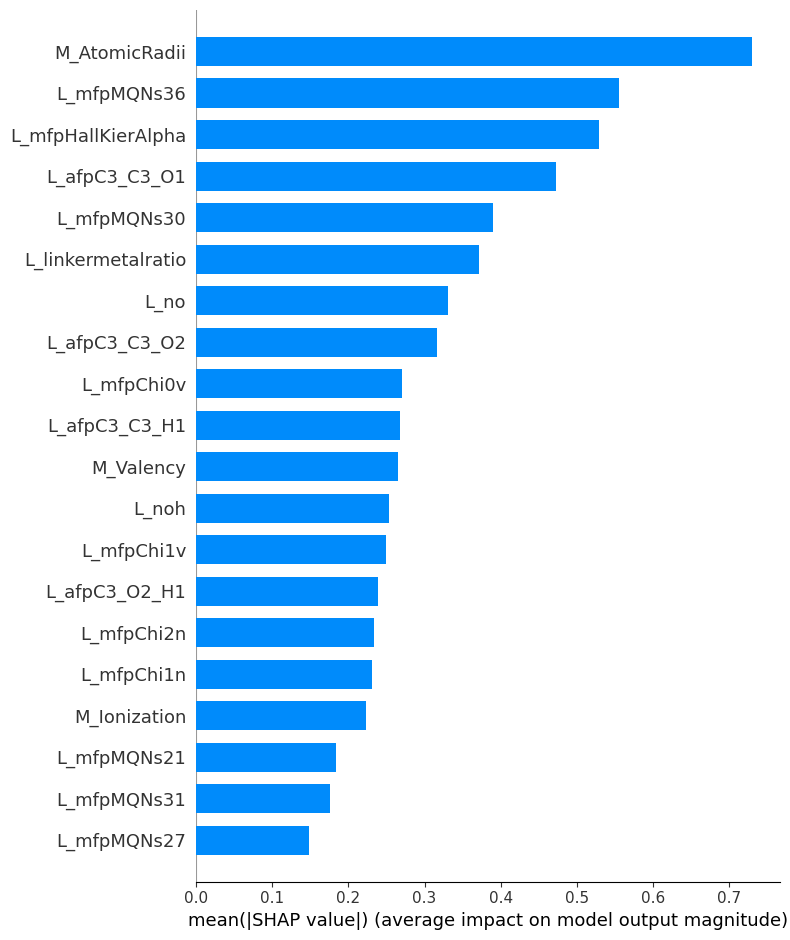

C:\Users\user\AppData\Local\Temp\ipykernel_35796\1723043984.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_train)


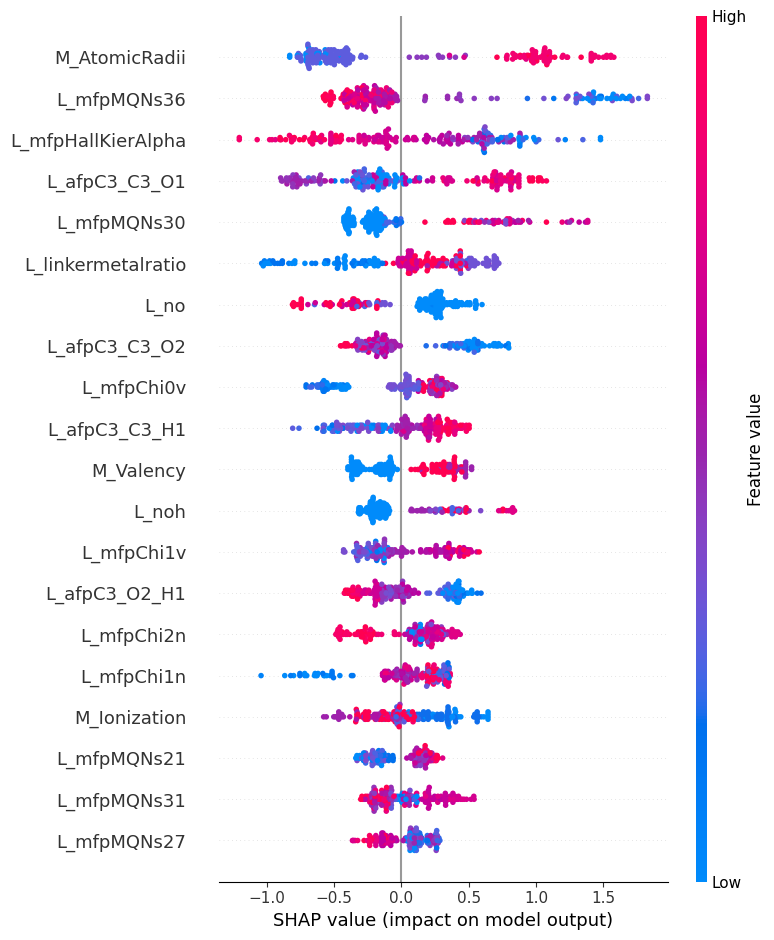

In [16]:
# ============================================================
# 11. Global SHAP Feature Importance (Full Training Set)
# ============================================================

# Train model on full 207-MOF training dataset
shap_model = clone(xgb_base)
shap_model.fit(X_train, y_train)

# TreeSHAP explainer (tree-based exact method)
explainer = shap.TreeExplainer(shap_model)

# Compute SHAP values for training set
shap_values = explainer(X_train)

# Extract SHAP values for positive class (binary classification)
if isinstance(shap_values.values, list):
    shap_vals = shap_values.values[1]
else:
    shap_vals = shap_values.values

# ------------------------------------------------------------
# Global SHAP Summary Plots
# ------------------------------------------------------------

# Bar plot: mean absolute SHAP importance
shap.summary_plot(shap_vals, X_train, plot_type="bar")

# Beeswarm plot: distribution of SHAP values
shap.summary_plot(shap_vals, X_train)


In [17]:
mean_abs_shap = np.abs(shap_vals).mean(axis=0)
shap_importance = pd.DataFrame({
    "feature": X_train.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

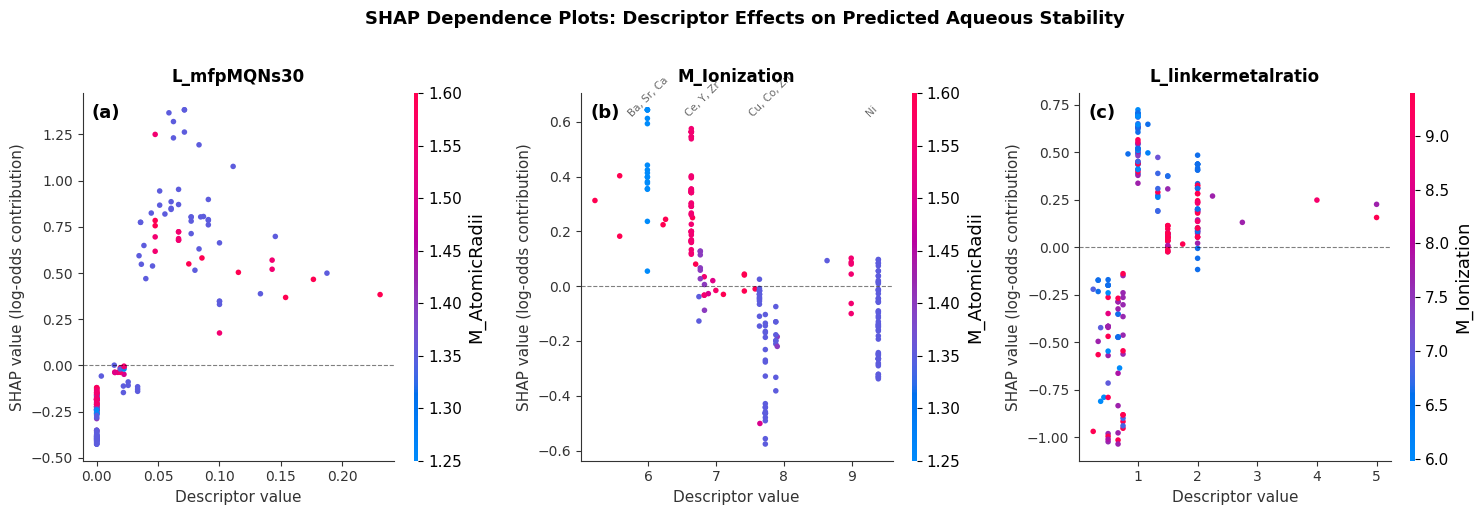

In [18]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# ============================================================
# SHAP Dependence Plots (one descriptor per chemical domain)
# Note: SHAP values are in log-odds space for TreeExplainer.
# ============================================================

features_to_plot = [
    "L_mfpMQNs30",
    "M_Ionization",
    "L_linkermetalratio"
]

# Interaction feature used for color-coding in each panel
interaction_features = [
    "M_AtomicRadii",
    "M_AtomicRadii",
    "M_Ionization"
]

panel_labels = ["(a)", "(b)", "(c)"]

# Approximate cluster annotations for the M_Ionization panel
metal_annotations = {
    6.0: "Ba, Sr, Ca",
    6.8: "Ce, Y, Zr",
    7.8: "Cu, Co, Zn",
    9.3: "Ni"
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)

for i, (ax, feature, interact) in enumerate(zip(axes, features_to_plot, interaction_features)):

    shap.dependence_plot(
        feature,
        shap_vals,     # IMPORTANT: use the processed SHAP array for positive class
        X_train,
        interaction_index=interact,
        ax=ax,
        show=False
    )

    ax.text(
        0.03, 0.97, panel_labels[i],
        transform=ax.transAxes,
        fontsize=13, fontweight="bold",
        va="top", ha="left"
    )

    ax.set_title(feature, fontsize=12, fontweight="bold", pad=8)
    ax.set_xlabel("Descriptor value", fontsize=11)
    ax.set_ylabel("SHAP value (log-odds contribution)", fontsize=11)
    ax.tick_params(axis="both", labelsize=10)

    ax.axhline(y=0, color="black", linewidth=0.8, linestyle="--", alpha=0.5)

    if feature == "M_Ionization":
        y_pos = ax.get_ylim()[1] * 0.88
        x_data = X_train[feature].values
        for x_val, label in metal_annotations.items():
            if np.any(np.abs(x_data - x_val) < 0.3):
                ax.annotate(
                    label,
                    xy=(x_val, y_pos),
                    fontsize=7.5,
                    ha="center",
                    color="dimgray",
                    rotation=45
                )

fig.suptitle(
    "SHAP Dependence Plots: Descriptor Effects on Predicted Aqueous Stability",
    fontsize=13,
    fontweight="bold",
    y=1.02
)

plt.tight_layout()

plt.savefig("Figure_SHAP_Dependence.pdf", dpi=600, bbox_inches="tight")
plt.savefig("Figure_SHAP_Dependence.png", dpi=600, bbox_inches="tight")
plt.savefig("Figure_SHAP_Dependence.jpg", dpi=600, format="jpeg", bbox_inches="tight")

plt.show()

In [19]:
# ============================================================
# 13. SHAP-Based Global Feature Ranking (Full Training Set)
# ============================================================

# Compute mean absolute SHAP value per feature
# (SHAP values are in log-odds space)
mean_abs_shap = np.abs(shap_vals).mean(axis=0)

# Construct ranking dataframe
shap_ranking = pd.DataFrame({
    "feature": X_train.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

# Display top-ranked features
display(shap_ranking.head(20))

# Store Top-20 feature list
top_20_features = shap_ranking["feature"].head(20).tolist()

top_20_features

,feature,mean_abs_shap
84,M_AtomicRadii,0.730012
73,L_mfpMQNs36,0.555114
56,L_mfpHallKierAlpha,0.528487
7,L_afpC3_C3_O1,0.471955
69,L_mfpMQNs30,0.389988
49,L_linkermetalratio,0.371470
81,L_no,0.330770
8,L_afpC3_C3_O2,0.316336
51,L_mfpChi0v,0.270716
4,L_afpC3_C3_H1,0.268154


['M_AtomicRadii',
 'L_mfpMQNs36',
 'L_mfpHallKierAlpha',
 'L_afpC3_C3_O1',
 'L_mfpMQNs30',
 'L_linkermetalratio',
 'L_no',
 'L_afpC3_C3_O2',
 'L_mfpChi0v',
 'L_afpC3_C3_H1',
 'M_Valency',
 'L_noh',
 'L_mfpChi1v',
 'L_afpC3_O2_H1',
 'L_mfpChi2n',
 'L_mfpChi1n',
 'M_Ionization',
 'L_mfpMQNs21',
 'L_mfpMQNs31',
 'L_mfpMQNs27']

In [20]:
# ============================================================
# 14. Export Top-20 SHAP-Ranked Features
# ============================================================

# `shap_ranking` is computed from mean absolute SHAP values
# on a model trained using the full 207-MOF training set.

top20_df = shap_ranking.head(20).copy()
top20_df.to_csv("xgb_top20_features.csv", index=False)

print("Saved Top-20 SHAP-ranked features to: xgb_top20_features.csv")
top20_df

Saved Top-20 SHAP-ranked features to: xgb_top20_features.csv


,feature,mean_abs_shap
84,M_AtomicRadii,0.730012
73,L_mfpMQNs36,0.555114
56,L_mfpHallKierAlpha,0.528487
7,L_afpC3_C3_O1,0.471955
69,L_mfpMQNs30,0.389988
49,L_linkermetalratio,0.371470
81,L_no,0.330770
8,L_afpC3_C3_O2,0.316336
51,L_mfpChi0v,0.270716
4,L_afpC3_C3_H1,0.268154


In [21]:
# ------------------------------------------------------------
# Distribution of SHAP global importance (mean |SHAP|)
# ------------------------------------------------------------
shap_ranking["mean_abs_shap"].describe()

count    88.000000
mean      0.101716
std       0.144739
min       0.000000
25%       0.000000
50%       0.046994
75%       0.141307
max       0.730012
Name: mean_abs_shap, dtype: float64

In [22]:
# ============================================================
# 15. Reduced-Descriptor Evaluation (Top-20 SHAP-Ranked Features)
# ============================================================

# Note: Feature ranking is derived from the full training set prior to CV,

top20_features = top_20_features  # reuse single source of truth

X_train_20 = X_train[top20_features].copy()
X_val_20   = X_val[top20_features].copy()
X_pred_20  = X_pred[top20_features].copy()

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

scores = []

for fold, (tr_idx, te_idx) in enumerate(skf.split(X_train_20, y_train), 1):
    model = clone(xgb_base)
    model.fit(X_train_20.iloc[tr_idx], y_train.iloc[tr_idx])

    proba = model.predict_proba(X_train_20.iloc[te_idx])[:, 1]
    pred  = (proba >= 0.5).astype(int)

    scores.append({
        "fold": fold,
        "roc_auc": roc_auc_score(y_train.iloc[te_idx], proba),
        "pr_auc": average_precision_score(y_train.iloc[te_idx], proba),
        "f1": f1_score(y_train.iloc[te_idx], pred),
        "balanced_accuracy": balanced_accuracy_score(y_train.iloc[te_idx], pred),
    })

cv_top20_df = pd.DataFrame(scores)

display(cv_top20_df)

summary = cv_top20_df[["roc_auc","pr_auc","f1","balanced_accuracy"]].agg(["mean","std"])
print("\nTop-20 CV performance (mean ± SD):")
display(summary)

,fold,roc_auc,pr_auc,f1,balanced_accuracy
0,1,0.647215,0.782610,0.819672,0.661804
1,2,0.899204,0.948750,0.862069,0.777188
2,3,0.818966,0.892902,0.881356,0.781609
3,4,0.846154,0.924667,0.836364,0.756868
4,5,0.925824,0.966437,0.945455,0.925824



Top-20 CV performance (mean ± SD):


,roc_auc,pr_auc,f1,balanced_accuracy
mean,0.827473,0.903073,0.868983,0.780659
std,0.109239,0.072771,0.048848,0.094576


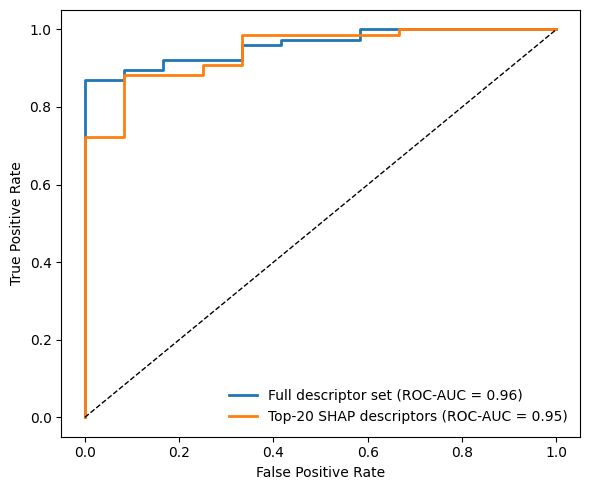

(0.9594298245614036, 0.9451754385964912)

In [23]:
# ============================================================
# 16. External Test Evaluation (Full vs Top-20)
# ============================================================

from sklearn.base import clone
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Fit final models on full training set
# ------------------------------------------------------------
xgb_full = clone(xgb_base).fit(X_train, y_train)
xgb_top20 = clone(xgb_base).fit(X_train_20, y_train)

# ------------------------------------------------------------
# Predict on independent external test set
# ------------------------------------------------------------
assert "y_pred" in globals(), "Ground-truth labels for external test set are not available."
y_true = y_pred

assert list(X_pred_20.columns) == list(X_train_20.columns), \
    "Top-20 feature misalignment between training and external test set."

y_proba_full  = xgb_full.predict_proba(X_pred)[:, 1]
y_proba_top20 = xgb_top20.predict_proba(X_pred_20)[:, 1]

# ROC-AUC (direct computation)
auc_full  = roc_auc_score(y_true, y_proba_full)
auc_top20 = roc_auc_score(y_true, y_proba_top20)

# ------------------------------------------------------------
# ROC curves (Manuscript Figure 2)
# ------------------------------------------------------------
fpr_full, tpr_full, _ = roc_curve(y_true, y_proba_full)
fpr_top20, tpr_top20, _ = roc_curve(y_true, y_proba_top20)

plt.figure(figsize=(6, 5))
plt.plot(fpr_full, tpr_full, lw=2,
         label=f"Full descriptor set (ROC-AUC = {auc_full:.2f})")
plt.plot(fpr_top20, tpr_top20, lw=2,
         label=f"Top-20 SHAP descriptors (ROC-AUC = {auc_top20:.2f})")
plt.plot([0, 1], [0, 1], "k--", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig("Figure2_XGBoost_Full_vs_Top20.pdf", bbox_inches="tight")
plt.savefig("Figure2_XGBoost_Full_vs_Top20.png", dpi=600, bbox_inches="tight")
plt.show()

auc_full, auc_top20

In [24]:
# ============================================================
# Table 1. External Test Metrics (Full vs Top-20)
# ============================================================

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score
)
import pandas as pd

# Ground-truth labels (external test set)
assert "y_pred" in globals(), "External test labels (y_pred) are not available."
y_true = y_pred

# Predicted probabilities
y_proba_full  = xgb_full.predict_proba(X_pred)[:, 1]
y_proba_top20 = xgb_top20.predict_proba(X_pred_20)[:, 1]

# Class predictions using default threshold (0.5)
y_full_cls  = (y_proba_full  >= 0.5).astype(int)
y_top20_cls = (y_proba_top20 >= 0.5).astype(int)

table1 = pd.DataFrame({
    "Model": ["XGBoost", "XGBoost"],
    "Feature Set": [f"Full ({X_train.shape[1]})", "Top-20 (SHAP)"],
    "ROC-AUC": [
        roc_auc_score(y_true, y_proba_full),
        roc_auc_score(y_true, y_proba_top20),
    ],
    "PR-AUC": [
        average_precision_score(y_true, y_proba_full),
        average_precision_score(y_true, y_proba_top20),
    ],
    "F1": [
        f1_score(y_true, y_full_cls),
        f1_score(y_true, y_top20_cls),
    ],
    "Balanced Accuracy": [
        balanced_accuracy_score(y_true, y_full_cls),
        balanced_accuracy_score(y_true, y_top20_cls),
    ],
})

# Optional: round for presentation
table1_rounded = table1.copy()
for col in ["ROC-AUC", "PR-AUC", "F1", "Balanced Accuracy"]:
    table1_rounded[col] = table1_rounded[col].round(3)

table1_rounded

,Model,Feature Set,ROC-AUC,PR-AUC,F1,Balanced Accuracy
0,XGBoost,Full (88),0.959,0.994,0.954,0.814
1,XGBoost,Top-20 (SHAP),0.945,0.991,0.954,0.814


In [25]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score
import pandas as pd
import numpy as np

# ============================================================
# Descriptor Parsimony Benchmark: CV + External Test Performance
# ============================================================

# Feature subset sizes to evaluate (Full and SHAP Top-k subsets)
full_k = X_train.shape[1]
subset_sizes = [full_k, 20, 15, 10, 3, 1]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

results = []

for k in subset_sizes:

    if k == full_k:
        feats = X_train.columns.tolist()
        label = f"Full ({full_k})"
    else:
        feats = shap_ranking["feature"].head(k).tolist()
        label = f"Top-{k}"

    X_tr_k = X_train[feats].copy()
    X_ext_k = X_pred[feats].copy()

    # -----------------------------
    # 5-fold stratified CV (ROC-AUC)
    # -----------------------------
    cv_aucs = []

    for tr_idx, te_idx in skf.split(X_tr_k, y_train):
        model = clone(xgb_base)
        model.fit(X_tr_k.iloc[tr_idx], y_train.iloc[tr_idx])

        proba = model.predict_proba(X_tr_k.iloc[te_idx])[:, 1]
        cv_aucs.append(roc_auc_score(y_train.iloc[te_idx], proba))

    cv_auc_mean = float(np.mean(cv_aucs))
    cv_auc_std  = float(np.std(cv_aucs, ddof=1))

    # -----------------------------
    # External test evaluation
    # -----------------------------
    final_model = clone(xgb_base)
    final_model.fit(X_tr_k, y_train)

    proba_ext = final_model.predict_proba(X_ext_k)[:, 1]
    pred_ext  = (proba_ext >= 0.5).astype(int)

    ext_auc = roc_auc_score(y_pred, proba_ext)
    ext_f1  = f1_score(y_pred, pred_ext)
    ext_bal = balanced_accuracy_score(y_pred, pred_ext)

    results.append({
        "Feature Set": label,
        "CV ROC-AUC (mean)": round(cv_auc_mean, 3),
        "CV ROC-AUC (SD)": round(cv_auc_std, 3),
        "External ROC-AUC": round(ext_auc, 3),
        "External F1": round(ext_f1, 3),
        "External Balanced Acc": round(ext_bal, 3),
    })

comparison_df = pd.DataFrame(results)
comparison_df

,Feature Set,CV ROC-AUC (mean),CV ROC-AUC (SD),External ROC-AUC,External F1,External Balanced Acc
0,Full (88),0.795,0.126,0.959,0.954,0.814
1,Top-20,0.827,0.109,0.945,0.954,0.814
2,Top-15,0.840,0.092,0.963,0.947,0.807
3,Top-10,0.855,0.101,0.907,0.940,0.800
4,Top-3,0.822,0.087,0.823,0.859,0.693
5,Top-1,0.672,0.054,0.798,0.927,0.500


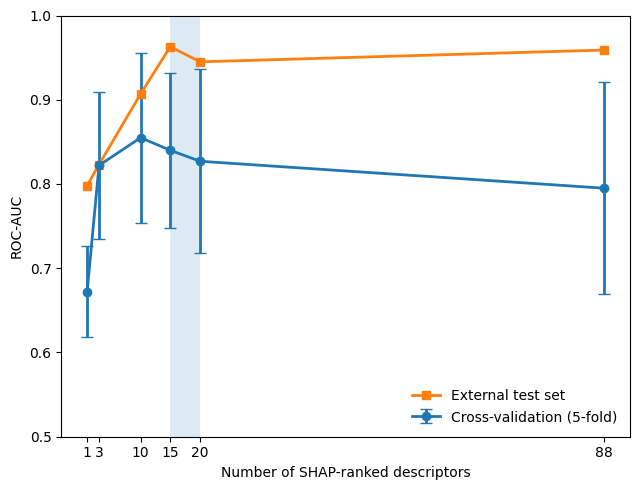

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ============================================================
# Figure: Performance vs Descriptor Count (CV and External Test)
# ============================================================

full_k = X_train.shape[1]
subset_sizes = [1, 3, 10, 15, 20, full_k]

# Build a plotting dataframe directly from comparison_df
plot_rows = []
for k in subset_sizes:
    label = f"Full ({full_k})" if k == full_k else f"Top-{k}"
    row = comparison_df[comparison_df["Feature Set"] == label].iloc[0].to_dict()
    row["n_features"] = k
    plot_rows.append(row)

fig2_df = pd.DataFrame(plot_rows).sort_values("n_features")

x = fig2_df["n_features"].values
cv_mean = fig2_df["CV ROC-AUC (mean)"].values
cv_err  = fig2_df["CV ROC-AUC (SD)"].values
ext_auc = fig2_df["External ROC-AUC"].values

plt.figure(figsize=(6.5, 5))

plt.errorbar(
    x, cv_mean, yerr=cv_err,
    fmt="o-", linewidth=2, capsize=4,
    label="Cross-validation (5-fold)"
)

plt.plot(
    x, ext_auc,
    "s-", linewidth=2,
    label="External test set"
)

# Highlight plateau region (15–20 descriptors)
plt.axvspan(15, 20, alpha=0.15)

plt.ylim(0.5, 1.0)
plt.xticks([1, 3, 10, 15, 20, full_k])

plt.xlabel("Number of SHAP-ranked descriptors")
plt.ylabel("ROC-AUC")
plt.legend(frameon=False)
plt.tight_layout()

plt.savefig("Figure_Dimensional_Plateau.pdf", bbox_inches="tight")
plt.savefig("Figure_Dimensional_Plateau.png", dpi=600, bbox_inches="tight")
plt.savefig("Figure_Dimensional_Plateau.tiff", dpi=600, format="tiff", bbox_inches="tight")
plt.savefig("Figure_Dimensional_Plateau.jpg", dpi=600, format="jpeg", bbox_inches="tight")

plt.show()

In [27]:
table1.to_csv("Table1_metrics.csv", index=False)


In [28]:
metal_features = [
    "M_AtomicRadii",
    "M_Valency",
    "M_Ionization"
]

linker_features = [
    "L_mfpMQNs36", "L_mfpMQNs30", "L_mfpMQNs21", "L_mfpMQNs31",
    "L_mfpHallKierAlpha",
    "L_mfpChi0v", "L_mfpChi1n", "L_mfpChi1v", "L_mfpChi2n",
    "L_linkermetalratio",
    "L_no", "L_noh",
    "L_afpC3_C3_O1", "L_afpC3_C3_O2", "L_afpC3_C3_H1",
    "L_afpC3_O2_H1", "L_afpO1_C3_O2"
]

framework_features = [
    # (none explicit here — important observation!)
]


In [29]:
# ============================================================
# Export Rounded Table 1 (for manuscript reporting)
# ============================================================

table1_rounded = table1.copy()

metric_cols = ["ROC-AUC", "PR-AUC", "F1", "Balanced Accuracy"]
table1_rounded[metric_cols] = table1_rounded[metric_cols].round(3)

table1_rounded.to_csv("Table1_metrics_rounded.csv", index=False)

print("Saved: Table1_metrics_rounded.csv")

Saved: Table1_metrics_rounded.csv


In [30]:
# ============================================================
# Build SHAP summary table for Top-20
# ============================================================
shap_top20 = shap_ranking.head(20).copy()

def assign_group(feature):
    feature = str(feature)
    if feature.startswith("M_"):
        return "Metal chemistry"
    elif feature.startswith("L_"):
        return "Linker descriptors"
    else:
        return "Framework / topology"

shap_top20["Group"] = shap_top20["feature"].apply(assign_group)

# Verify the fix - check L_mfpMQNs27 is now Framework/topology
print(shap_top20[["feature", "mean_abs_shap", "Group"]].to_string())

               feature  mean_abs_shap               Group
84       M_AtomicRadii       0.730012     Metal chemistry
73         L_mfpMQNs36       0.555114  Linker descriptors
56  L_mfpHallKierAlpha       0.528487  Linker descriptors
7        L_afpC3_C3_O1       0.471955  Linker descriptors
69         L_mfpMQNs30       0.389988  Linker descriptors
49  L_linkermetalratio       0.371470  Linker descriptors
81                L_no       0.330770  Linker descriptors
8        L_afpC3_C3_O2       0.316336  Linker descriptors
51          L_mfpChi0v       0.270716  Linker descriptors
4        L_afpC3_C3_H1       0.268154  Linker descriptors
87           M_Valency       0.264508     Metal chemistry
82               L_noh       0.253332  Linker descriptors
53          L_mfpChi1v       0.249134  Linker descriptors
19       L_afpC3_O2_H1       0.239339  Linker descriptors
54          L_mfpChi2n       0.233047  Linker descriptors
52          L_mfpChi1n       0.230762  Linker descriptors
86        M_Io

In [31]:
# ============================================================
# Aggregate SHAP Importance by Chemical Domain (Top-20)
# ============================================================

group_importance = (
    shap_top20
    .groupby("Group")["mean_abs_shap"]
    .sum()
    .sort_values(ascending=False)
)

# Normalize to fractional contribution
group_fraction = (group_importance / group_importance.sum()).round(3)

group_summary = pd.DataFrame({
    "Total Importance": group_importance.round(3),
    "Fraction of Top-20": group_fraction
})

group_summary

,Total Importance,Fraction of Top-20
Group,,
Linker descriptors,5.216,0.811
Metal chemistry,1.218,0.189


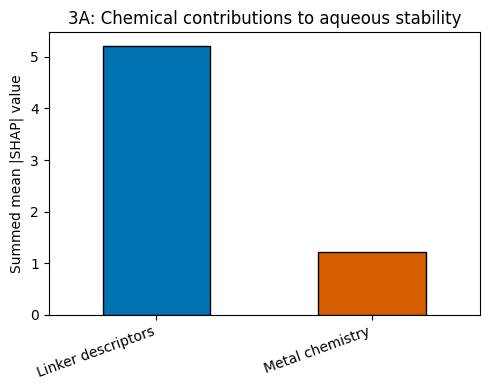

In [32]:
import matplotlib.pyplot as plt

# Consistent color scheme
color_map = {
    "Linker descriptors": "#0072B2",   # blue
    "Metal chemistry": "#D55E00",      # orange
    "Framework / topology": "#009E73"  # green (if present later)
}

# Map colors to bars
bar_colors = [color_map[g] for g in group_importance.index]

plt.figure(figsize=(5,4))
group_importance.plot(
    kind="bar",
    color=bar_colors,
    edgecolor="black"
)

plt.ylabel("Summed mean |SHAP| value")
plt.xlabel("")
plt.title("3A: Chemical contributions to aqueous stability")

plt.xticks(rotation=20, ha="right")
plt.tight_layout()

plt.savefig("Figure3A_SHAP_Grouped_Importance.pdf")
plt.savefig("Figure3A_SHAP_Grouped_Importance.png", dpi=600)
plt.savefig("Figure3A_SHAP_Grouped_Importance.jpg", dpi=600, format="jpeg")
plt.show()


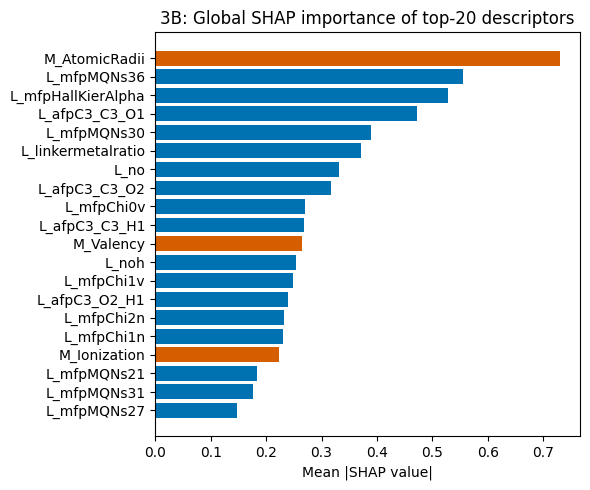

In [33]:
color_map = {
    "Metal chemistry": "#D55E00",
    "Linker descriptors": "#0072B2",
    "Framework / topology": "#009E73"
}

plt.figure(figsize=(6,5))
plt.barh(
    shap_top20["feature"],
    shap_top20["mean_abs_shap"],
    color=shap_top20["Group"].map(color_map)
)

plt.xlabel("Mean |SHAP value|")
plt.gca().invert_yaxis()
plt.title("3B: Global SHAP importance of top-20 descriptors")
plt.tight_layout()

plt.savefig("Figure3B_SHAP_Top20_By_Chemistry.pdf")
plt.savefig("Figure3B_SHAP_Top20_By_Chemistry.png", dpi=600)
plt.savefig("Figure3B_SHAP_Top20_By_Chemistry.jpg", dpi=600, format="jpeg")
plt.show()


Top-20 features present in prediction set: 20
Missing Top-20 features: []

Top-20 XGBoost performance on external prediction dataset:
ROC-AUC: 0.945
PR-AUC: 0.991
F1: 0.954
Balanced Accuracy: 0.814
Accuracy: 0.920


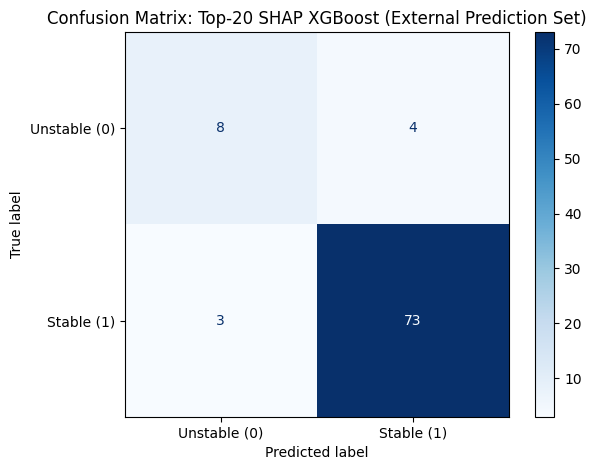

In [34]:
# ============================================================
# FINAL Top-20 Model Evaluation 
# ============================================================

from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Define label column
# -----------------------------
LABEL_COL = "Stability_binary"

# -----------------------------
# Ensure Top-20 features exist in prediction dataset
# -----------------------------
top20_present = [f for f in top20_features if f in X_pred.columns]
missing = sorted(set(top20_features) - set(top20_present))

print("Top-20 features present in prediction set:", len(top20_present))
print("Missing Top-20 features:", missing)

# Build Top-20 prediction matrix
X_pred_20 = X_pred[top20_present].copy()

# Ground-truth labels
y_pred_true = pred_df[LABEL_COL].astype(int)

# -----------------------------
# Train final Top-20 model
# (Using SAME hyperparameters as dimensionality study)
# -----------------------------
xgb_top20_final = clone(xgb_base)
xgb_top20_final.fit(X_train[top20_present], y_train)

# -----------------------------
# Predict on external dataset
# -----------------------------
proba_pred = xgb_top20_final.predict_proba(X_pred_20)[:, 1]
y_pred_hat = (proba_pred >= 0.5).astype(int)

# -----------------------------
# Performance metrics
# -----------------------------
metrics = {
    "ROC-AUC": roc_auc_score(y_pred_true, proba_pred),
    "PR-AUC": average_precision_score(y_pred_true, proba_pred),
    "F1": f1_score(y_pred_true, y_pred_hat),
    "Balanced Accuracy": balanced_accuracy_score(y_pred_true, y_pred_hat),
    "Accuracy": accuracy_score(y_pred_true, y_pred_hat)
}

print("\nTop-20 XGBoost performance on external prediction dataset:")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# -----------------------------
# Confusion matrix (Supplementary Figure)
# -----------------------------
cm = confusion_matrix(y_pred_true, y_pred_hat, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Unstable (0)", "Stable (1)"]
)

disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix: Top-20 SHAP XGBoost (External Prediction Set)")
plt.tight_layout()

plt.savefig("FigureS1_ConfusionMatrix_Top20_XGBoost.pdf")
plt.savefig("FigureS1_ConfusionMatrix_Top20_XGBoost.png", dpi=600)
plt.show()


In [35]:
proba_pred = xgb_top20_final.predict_proba(X_pred_20)[:, 1]
y_pred_hat = (proba_pred >= 0.5).astype(int)

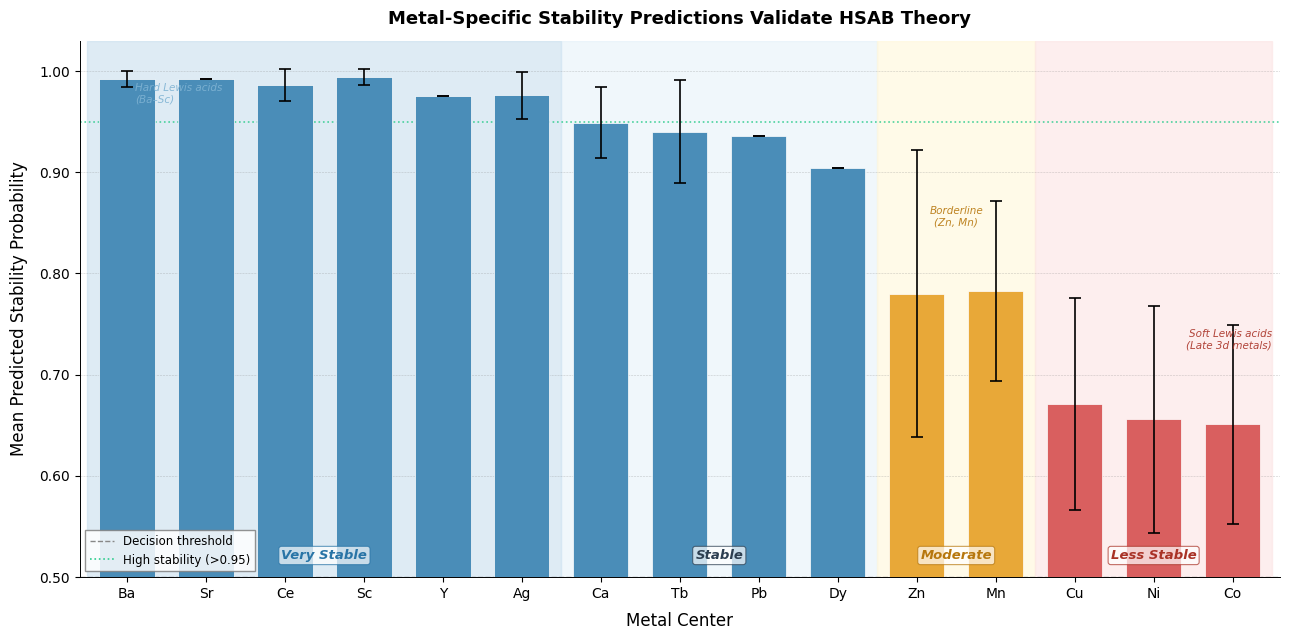

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import ast

# ============================================================
# FIGURE 5 — Metal-Specific Predicted Stability (HSAB Validation)
# ============================================================

# Metals in exact left-to-right order
metals     = ["Ba",  "Sr",   "Ce",   "Sc",   "Y",    "Ag",
              "Ca",  "Tb",   "Pb",   "Dy",
              "Zn",  "Mn",
              "Cu",  "Ni",   "Co"]

mean_probs = [0.992, 0.992,  0.986,  0.994,  0.975,  0.976,
              0.949, 0.940,  0.936,  0.904,
              0.780, 0.783,
              0.671, 0.656,  0.651]

std_devs   = [0.008, np.nan, 0.016,  0.008,  np.nan, 0.023,
              0.035, 0.051,  np.nan, np.nan,
              0.142, 0.089,
              0.105, 0.112,  0.098]

# Bar colors per group
bar_colors = (
    ["#4A8DB8"] * 6 +   # Very Stable
    ["#4A8DB8"] * 4 +   # Stable
    ["#E8A838"] * 2 +   # Moderate
    ["#D95F5F"] * 3     # Less Stable
)

# ============================================================
# FIGURE SETUP
# ============================================================
fig, ax = plt.subplots(figsize=(13, 6.5))
fig.patch.set_facecolor("white")
x = np.arange(len(metals))

# Background shading per group
group_bg = [
    (0,  5,  "#C8DFEE", 0.60),   # Very Stable — medium light blue
    (6,  9,  "#D6E9F5", 0.35),   # Stable — lighter blue
    (10, 11, "#FFF8DC", 0.65),   # Moderate — light amber
    (12, 14, "#FCE4E4", 0.60),   # Less Stable — light red
]
for start, end, color, alpha in group_bg:
    ax.axvspan(start - 0.5, end + 0.5, color=color, alpha=alpha, zorder=0)

# Reference lines
ax.axhline(0.5,  linestyle="--", linewidth=1.0, color="#888888",
           alpha=0.8, zorder=1, label="Decision threshold")
ax.axhline(0.95, linestyle=":",  linewidth=1.2, color="#2ECC8E",
           alpha=0.85, zorder=1, label="High stability (>0.95)")

# Bars with error bars (NaN std = no error bar)
yerr_vals = np.where(np.isnan(std_devs), 0, std_devs)
bars = ax.bar(
    x, mean_probs,
    yerr=yerr_vals,
    capsize=4,
    color=bar_colors,
    edgecolor="white",
    linewidth=0.5,
    width=0.7,
    zorder=3,
    error_kw={"elinewidth": 1.2, "ecolor": "black", "capthick": 1.2, "zorder": 4}
)

# Stability category labels at bottom
label_cfg = [
    ("Very Stable", 2.5,  "#2874A6", "bold"),
    ("Stable",      7.5,  "#2C3E50", "bold"),
    ("Moderate",    10.5, "#B7770D", "bold"),
    ("Less Stable", 13.0, "#A93226", "bold"),
]
for text, xpos, color, weight in label_cfg:
    ax.text(xpos, 0.515, text,
            ha="center", va="bottom",
            fontsize=9.5, fontstyle="italic", fontweight=weight,
            color=color, zorder=5,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white",
                      edgecolor=color, alpha=0.7, linewidth=0.8))

# In-plot text annotations
ax.text(0.1, 0.988, "Hard Lewis acids\n(Ba–Sc)",
        ha="left", va="top", fontsize=7.5, fontstyle="italic",
        color="#7FB3D3", alpha=0.9, zorder=6)

ax.text(10.5, 0.845, "Borderline\n(Zn, Mn)",
        ha="center", va="bottom", fontsize=7.5, fontstyle="italic",
        color="#B7770D", alpha=0.9, zorder=6)

ax.text(14.5, 0.745, "Soft Lewis acids\n(Late 3d metals)",
        ha="right", va="top", fontsize=7.5, fontstyle="italic",
        color="#A93226", alpha=0.9, zorder=6)

# Axes formatting
ax.set_xlim(-0.6, len(metals) - 0.4)
ax.set_ylim(0.50, 1.03)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticklabels(["0.50", "0.60", "0.70", "0.80", "0.90", "1.00"], fontsize=10)
ax.set_xticks(x)
ax.set_xticklabels(metals, fontsize=10, rotation=0)
ax.set_xlabel("Metal Center", fontsize=12, labelpad=8)
ax.set_ylabel("Mean Predicted Stability Probability", fontsize=12, labelpad=8)
ax.set_title("Metal-Specific Stability Predictions Validate HSAB Theory",
             fontsize=13, fontweight="bold", pad=12)

ax.yaxis.grid(True, linestyle="--", linewidth=0.4, color="gray", alpha=0.4, zorder=0)
ax.set_axisbelow(True)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)

# Legend
legend_lines = [
    plt.Line2D([0], [0], linestyle="--", color="#888888",
               linewidth=1.0, label="Decision threshold"),
    plt.Line2D([0], [0], linestyle=":",  color="#2ECC8E",
               linewidth=1.2, label="High stability (>0.95)"),
]
ax.legend(handles=legend_lines, loc="lower left",
          fontsize=8.5, framealpha=0.85, edgecolor="gray", fancybox=False)

plt.tight_layout()

# Save
plt.savefig("Figure5_Metal_Stability_HSAB.pdf", bbox_inches="tight", dpi=300)
plt.savefig("Figure5_Metal_Stability_HSAB.png", bbox_inches="tight", dpi=600)
plt.savefig("Figure5_Metal_Stability_HSAB.jpg", bbox_inches="tight", dpi=600, format="jpeg")
plt.show()

In [37]:
# ----------------------------------
# Collect prediction results
# ----------------------------------
results_df = pred_df.copy()

results_df["y_true"] = y_pred_true.values
results_df["y_pred"] = y_pred_hat
results_df["y_proba"] = proba_pred

# ----------------------------------
# Identify misclassified samples
# ----------------------------------
misclassified = results_df[results_df["y_true"] != results_df["y_pred"]].copy()

print("Number of misclassified MOFs:", misclassified.shape[0])

# ----------------------------------
# Select informative columns (adjust names if needed)
# ----------------------------------
cols_to_show = [
    "MOF_ID",
    "MOF_name",
    "y_true",
    "y_pred",
    "y_proba"
]

cols_to_show = [c for c in cols_to_show if c in misclassified.columns]

misclassified[cols_to_show].sort_values("y_proba")



Number of misclassified MOFs: 7


,y_true,y_pred,y_proba
71,1,0,0.199324
20,1,0,0.292318
42,1,0,0.463810
85,0,1,0.668451
7,0,1,0.769488
48,0,1,0.801788
80,0,1,0.932360


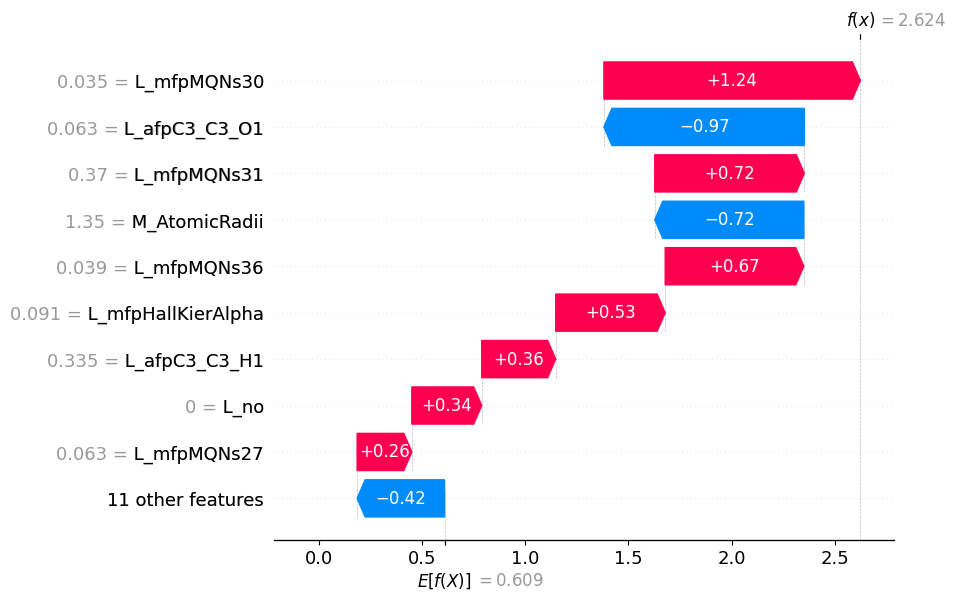

Top-15 features: ['M_AtomicRadii', 'L_mfpMQNs36', 'L_mfpHallKierAlpha', 'L_afpC3_C3_O1', 'L_mfpMQNs30', 'L_linkermetalratio', 'L_no', 'L_afpC3_C3_O2', 'L_mfpChi0v', 'L_afpC3_C3_H1', 'M_Valency', 'L_noh', 'L_mfpChi1v', 'L_afpC3_O2_H1', 'L_mfpChi2n']
Top-10 features: ['M_AtomicRadii', 'L_mfpMQNs36', 'L_mfpHallKierAlpha', 'L_afpC3_C3_O1', 'L_mfpMQNs30', 'L_linkermetalratio', 'L_no', 'L_afpC3_C3_O2', 'L_mfpChi0v', 'L_afpC3_C3_H1']


In [44]:
# ----------------------------------------------------
# 2) SHAP waterfall for one external sample (e.g. index 80)
# ----------------------------------------------------

import shap

explainer_final = shap.TreeExplainer(xgb_top20_final)

sample_index = 80   # change if needed
shap_values_single = explainer_final(X_pred_20.iloc[[sample_index]])

shap.plots.waterfall(shap_values_single[0])

# ----------------------------------------------------
# 3) Define Top-15 and Top-10 feature lists
# ----------------------------------------------------

top15_features = shap_ranking.head(15)["feature"].tolist()  
top10_features = shap_ranking.head(10)["feature"].tolist()  

print("Top-15 features:", top15_features)
print("Top-10 features:", top10_features)


In [41]:
# ============================================================
# Table 2: 10-MOF Post-Publication Validation Set
# Ground truth loaded from separate file (Batra et al. Table 2)
# S/HK = stable (1), LK = likely degraded (0)
# ============================================================
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.base import clone

# Load ground truth from separate file — keeps validationdata_binary.csv unchanged
gt_df      = pd.read_csv("validation_groundtruth.csv")
y_val_true = gt_df["Stability_binary"].astype(int)
gt_df["chemical_name"] = gt_df["chemical_name"].str.strip()
gt_df      = pd.read_csv("validation_groundtruth.csv")
gt_df["chemical_name"] = gt_df["chemical_name"].str.strip()  # ← remove trailing spaces
y_val_true = gt_df["Stability_binary"].astype(int)

# Verify correct distribution
assert y_val_true.sum() == 9 and len(y_val_true) == 10, \
    "Unexpected label distribution — check validation_groundtruth.csv"
print("Label check passed: 9 stable, 1 unstable")
print("Unstable MOF:", gt_df.loc[y_val_true == 0, "chemical_name"].values[0])
print()

# Feature subsets matching Table 2
models_to_eval = {
    "Full (88 descriptors)": (X_val,                 X_train),
    "Top-20 SHAP Model":     (X_val[top20_features], X_train[top20_features]),
    "Top-15 SHAP Model":     (X_val[top15_features], X_train[top15_features]),
    "Top-10 SHAP Model":     (X_val[top10_features], X_train[top10_features]),
}

table2_results = []
for model_name, (X_val_subset, X_train_subset) in models_to_eval.items():
    model = clone(xgb_base)
    model.fit(X_train_subset, y_train)
    preds = model.predict(X_val_subset)

    acc = accuracy_score(y_val_true, preds)
    bal = balanced_accuracy_score(y_val_true, preds)

    wrong_idx   = [j for j, (t, p) in enumerate(zip(y_val_true, preds)) if t != p]
    wrong_names = gt_df.iloc[wrong_idx]["chemical_name"].tolist()

    table2_results.append({
        "Model":             model_name,
        "Accuracy":          round(acc, 2),
        "Balanced Accuracy": round(bal, 2),
        "Misclassified MOF": ", ".join(wrong_names) if wrong_names else "None"
    })

table2_df = pd.DataFrame(table2_results)
print("Table 2: Validation on Batra et al. 10-MOF Post-Publication Set\n")
display(table2_df)

Label check passed: 9 stable, 1 unstable
Unstable MOF: [Cd2(TBA)2(bipy)(DMA)2]

Table 2: Validation on Batra et al. 10-MOF Post-Publication Set



,Model,Accuracy,Balanced Accuracy,Misclassified MOF
0,Full (88 descriptors),0.9,0.5,[Cd2(TBA)2(bipy)(DMA)2]
1,Top-20 SHAP Model,0.9,0.5,[Cd2(TBA)2(bipy)(DMA)2]
2,Top-15 SHAP Model,0.9,0.5,[Cd2(TBA)2(bipy)(DMA)2]
3,Top-10 SHAP Model,0.9,0.5,[Cd2(TBA)2(bipy)(DMA)2]
